# Introduction

On the notebook "determining_redshifht", I used a random sample of 15000 stellar objects(5000 of stars, QSOs and galaxxies) from the SDSS catalogue to determing the redshifts (z, distance measurement)of the stellar objects. In order to calculate z, I use the magnitudes of the 5 SDSS bands of each stellar object. To do this, I used two regression learning algorithms( KNearest Neighbor and Support Vector Machine). I compared the resulting values of mean squared error(mse) of the predicted values to spectroscopic z with the mse of the photometric z provided by the SDSS to its spectroscopic counterpart. I found that the mse of the last one to be 0.054 and the mse of the predicted values to be 0.186. This value which is too high, i found that it was due to the presence of higher z. Separaing the sample by z= 1, the mse of the best model for sources with z <=1 to be 0.008 and for the other subsample to be 0.099. I use neural networks to predict the values of z. I then used Neural Network without(mse 0.145) and then with colours( mse 0.132). 

In this notebook, I explore wether adding more sources with redshifht > 1 will improve the mse of the predictions.

# Data analysis

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib inline

# Loading data and EDA

In [2]:
#loading files
filepath= "/home/veroastro/Documents/spectraTypes/MLphotometry/data/"
galaxy = pd.read_csv(filepath+"galaxy_rand5.csv")
star = pd.read_csv(filepath+"star_rand.csv")
QSO = pd.read_csv(filepath+"QSO_rand.csv")

print(f'Number of data points in the star dataframe {star["z"].count()}')
print(f'Number of data points in the OSO dataframe {QSO["z"].count()}')
print(f'Number of data points in the galaxy dataframe {galaxy["z"].count()}')

Number of data points in the star dataframe 3671
Number of data points in the OSO dataframe 5000
Number of data points in the galaxy dataframe 5000


The combined dataset will be imbalance towards stars. The SQL script is the same for all classes but for some reason the obtained star dataset is smaller than the QSO and galaxy datasets.

In [3]:
#Create the data frame from the three sets of data
data = pd.concat([star, QSO, galaxy])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data = data.sample(frac=1)

data.shape

(13671, 19)

In [4]:
data_clean = data.drop(columns=['zWarning','objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass', 'photoZ','photoErr','type'])
data_clean.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
3748,21.13381,20.45098,20.20530,19.80453,19.56889,0.659723
46,20.16783,18.44941,17.22184,16.75263,16.37459,0.177453
3249,18.75599,18.67725,18.50685,18.44994,17.72321,0.352806
2979,20.36064,19.90151,19.20784,18.98388,18.48863,0.328878
1940,18.69496,16.86688,15.96555,15.52617,15.18298,0.075933


In [5]:
def hist_plots( data: pd.DataFrame,
               rows: int,
              cols: int,
              figsize: tuple):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{(data.columns)[i]} distribution', fontsize=10)
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.get_yaxis().get_label().set_visible(False)
            # Making it pretty with frame and grid
            ax.spines['top'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['top'].set_linewidth(1)
            ax.spines['right'].set_linewidth(1)
            ax.spines['bottom'].set_linewidth(1)
            ax.spines['left'].set_linewidth(1)
            ax.grid(color='b', linestyle='-', linewidth=0.5)
            ax.set_facecolor('xkcd:white')
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

## Sampling without photoZ values

In the histogram before, the values of the redshift sample mainly the population of objects with redshifts between 0-0.8. This bias may affect mostly galaxies and QSOs In this section, I check if by not constraining the data to have photoZ values if it also contrains the range of redshifts sampled. I use the same method and sql script as the original data but remove the values of photoZ and photoErr and with that also the inner join to the PhotoZ table.

In [6]:
new_galaxy = pd.read_csv(filepath+"galaxy_nophotoZ4.csv")
new_star = pd.read_csv(filepath+"star_nophotoZ.csv")
new_QSO = pd.read_csv(filepath+"QSO_nophotoZ.csv")
extra_z = pd.read_csv(filepath+"highZ.csv")
#Create the data frame from the three sets of data
data_nophoto = pd.concat([new_star, new_QSO, new_galaxy, extra_z])
#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data_nophoto = data_nophoto.sample(frac=1)
data_nophoto.describe()

,objID,type,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,z,zErr,zWarning
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,2.000000e+04,20000.0
mean,1.237663e+18,5.195250,19.408312,0.043173,18.549213,0.010752,18.183921,0.011060,17.994293,0.012927,17.864113,0.036488,8.622533e-01,1.967128e-04,0.0
std,7.646793e+12,1.329179,1.031507,0.022679,1.276383,0.005642,1.455134,0.006727,1.529938,0.008521,1.575814,0.027468,9.377299e-01,3.277573e-04,0.0
min,1.237646e+18,3.000000,7.552934,0.003263,7.661058,0.000773,8.319589,0.000540,10.746470,0.000361,8.741409,0.001826,5.417808e-09,2.446185e-07,0.0
25%,1.237658e+18,3.000000,18.862427,0.025025,17.752275,0.006469,17.105070,0.005618,16.784280,0.005862,16.584933,0.012720,2.190941e-03,1.277849e-05,0.0
50%,1.237662e+18,6.000000,19.543140,0.039747,18.658460,0.009398,18.426430,0.009054,18.302120,0.010392,18.229885,0.028137,2.034847e-01,4.446151e-05,0.0
75%,1.237667e+18,6.000000,20.141998,0.058602,19.581840,0.014163,19.417122,0.015366,19.308055,0.018459,19.232980,0.056469,1.689518e+00,3.274784e-04,0.0
max,1.237681e+18,6.000000,21.578460,0.099982,22.145940,0.089225,21.324990,0.077705,21.340340,0.087281,20.616610,0.099985,6.429002e+00,2.278432e-02,0.0


In [8]:
# checking for duplicates and removing them prom the dataset
print(sum(data_nophoto.duplicated()))
full_data = data_nophoto.drop_duplicates(keep='last').copy()
print(full_data.shape)

73
(19927, 17)


In [9]:
# converting class from categorical to numerical
def type_to_value(n):
    if n == 'STAR':
        return 1
    elif n == 'QSO':
        return 2
    elif n == 'GALAXY':
        return 3
    

data['nClass'] = [type_to_value(n) for n in data['class']]
full_data['nClass'] = [type_to_value(n) for n in full_data['class']]

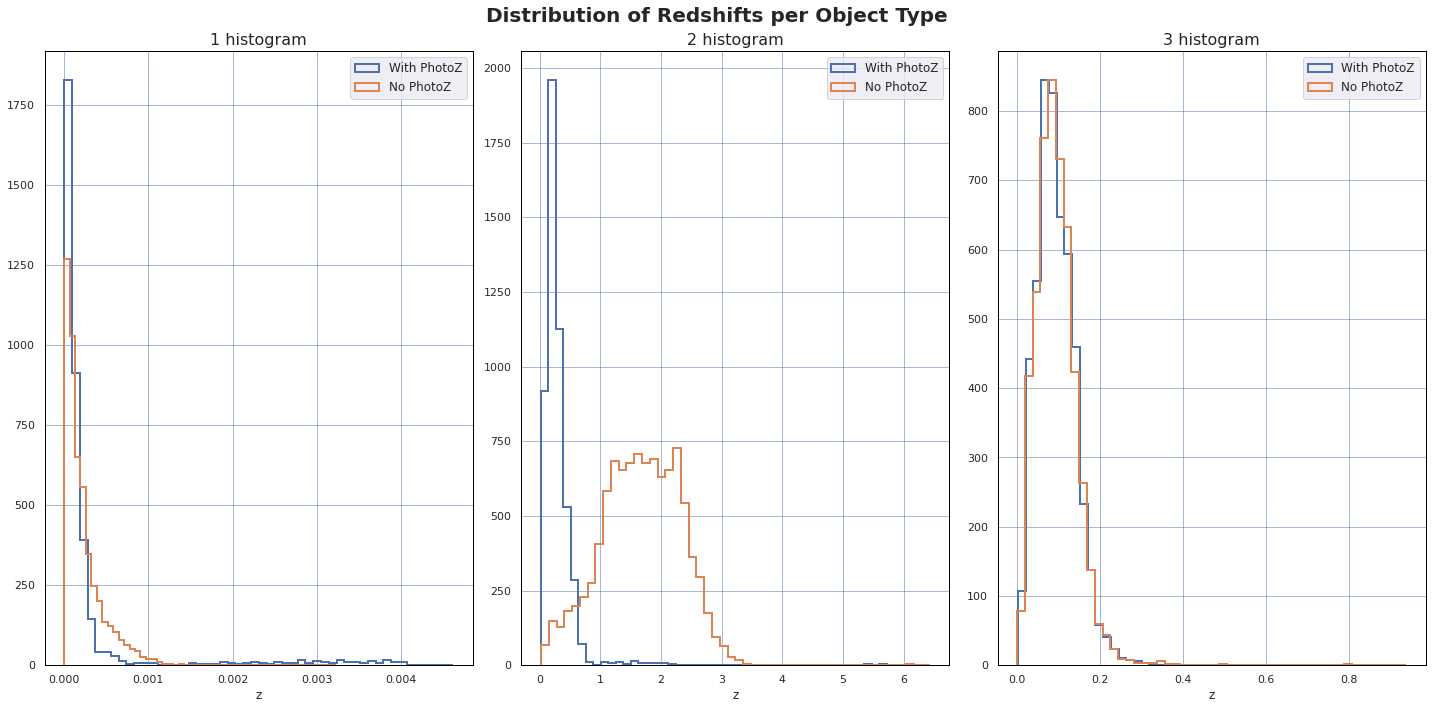

In [10]:
# Plotting the distributions of redshifts (z and photoZ) for each class (star, QSO, galaxy)
bins= 50

cols = [1, 2, 3]
fig,axs = plt.subplots(1,3, figsize=(20,10), edgecolor='black')
axs = axs.ravel()

for i, n in enumerate(cols):
    ax = axs[i]
    if i < len(cols):
        #create the histograms for the object type per band
        ax.hist(data[data['nClass']== n]['z'],bins= bins,histtype='step', linewidth=2,label='With PhotoZ')
        ax.hist(full_data[full_data['nClass']== n]['z'],bins= bins,histtype='step', linewidth=2, label='No PhotoZ')
        # Making it pretty with frame and grid
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        ax.grid(color='b', linestyle='-', linewidth=0.5)
        ax.set_facecolor('xkcd:white')
        #set legend, lables and title
        ax.legend(loc='upper right',fontsize=12)
        ax.set_xlabel('z')
        ax.set_title(f'{n} histogram', fontsize=16)
    else:
        fig.delaxes(ax=ax)
            
fig.suptitle('Distribution of Redshifts per Object Type', fontsize=20, fontweight="bold")
fig.tight_layout()
plt.show()

Both distributions of spectroscopic redshifts (z) for the datasets with and without photometric redshift contraint are very similar for the class 1(star) and class 3(galaxy). For the class2(QSO), both distributions are quite different. The distribution of photoZ has values mostly in the region between 0 and 1. While the distribution of z has values mostly between 0 and 3. 

Because of this and the fact that without the photoZ contraint the  dataset is balanced, I decided that for building the models to determine redshift I will use the dataset without photometric constraint.

## Prepping new dataset

In [11]:
data_cl = full_data.drop(columns=['zWarning','objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'subClass','type'])
data_cl.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
1306,20.67431,20.25327,20.03435,19.98915,19.71827,2.456878,2
668,20.13697,20.03177,19.75809,19.74050,19.90595,1.060059,2
837,18.26477,17.86617,17.68207,17.46004,17.20513,2.122566,2
2614,19.20903,18.96301,18.66391,18.76042,18.88937,1.100385,2
2175,21.05627,20.74837,20.52937,20.29080,20.22308,2.020439,2


## Looking at magnitudes and colours for the data_nophoto 

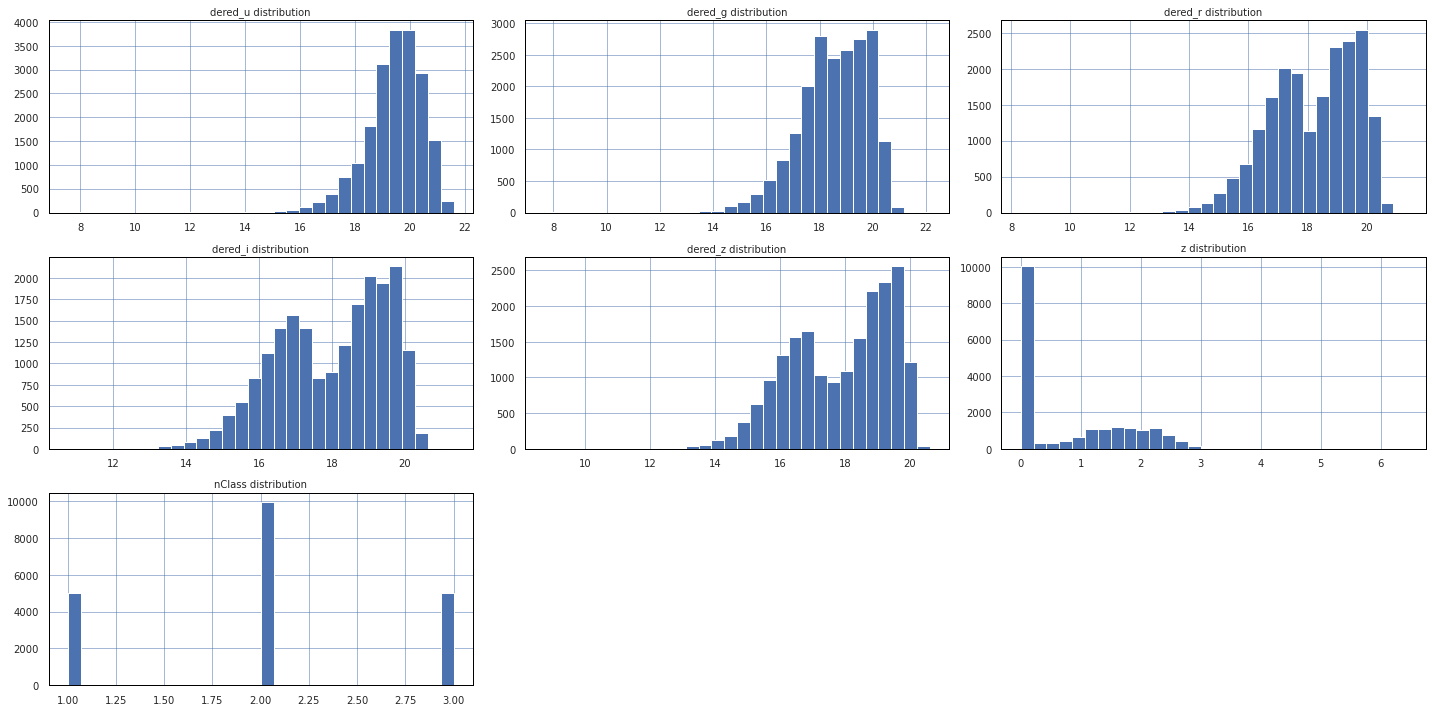

In [12]:
hist_plots(data=data_cl,
          rows=3,
          cols=3,
          figsize=(20,10))

The distribution of the magnitudes per band doesn't have a normal distribution. This could be due to the fact that I am combining different populations.

In [14]:
# Create a function to calculate the colours of the sources
def compute_colour(row):
    u = row['dered_u']
    g = row['dered_g']
    r = row['dered_r']
    i = row['dered_i']
    z = row['dered_z']
    return pd.Series({'u-g': u - g, 'g-r': g - r, 'r-i': r - i, 'i-z': i - z})
# Apply the function compute_colour
colour_ind = data_cl.apply(compute_colour, axis=1)
# Create new dataframe with the colours added
data_colour = pd.concat([data_cl,colour_ind], axis=1)
data_colour.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass,u-g,g-r,r-i,i-z
count,19927.000000,19927.000000,19927.000000,19927.000000,19927.000000,1.992700e+04,19927.000000,19927.000000,19927.000000,19927.000000,19927.000000
mean,19.407376,18.546094,18.180051,17.990035,17.859543,8.590588e-01,2.000000,0.861282,0.366043,0.190016,0.130492
std,1.032306,1.276988,1.455812,1.530524,1.576298,9.374700e-01,0.708419,0.659448,0.339882,0.187343,0.169282
min,7.552934,7.661058,8.319589,10.746470,8.741409,5.417808e-09,1.000000,-1.512210,-1.709300,-3.861471,-1.146380
25%,18.860940,17.748730,17.101655,16.779930,16.579515,1.207272e-03,1.000000,0.254505,0.104440,0.066465,0.016445
50%,19.541950,18.652150,18.417720,18.290460,18.221180,1.936482e-01,2.000000,0.848880,0.284710,0.175490,0.118090
75%,20.141750,19.579060,19.415765,19.305960,19.231525,1.687586e+00,3.000000,1.339790,0.591615,0.333715,0.253705
max,21.578460,22.145940,21.324990,21.340340,20.616610,6.429002e+00,3.000000,3.653620,3.852890,1.688770,3.762850


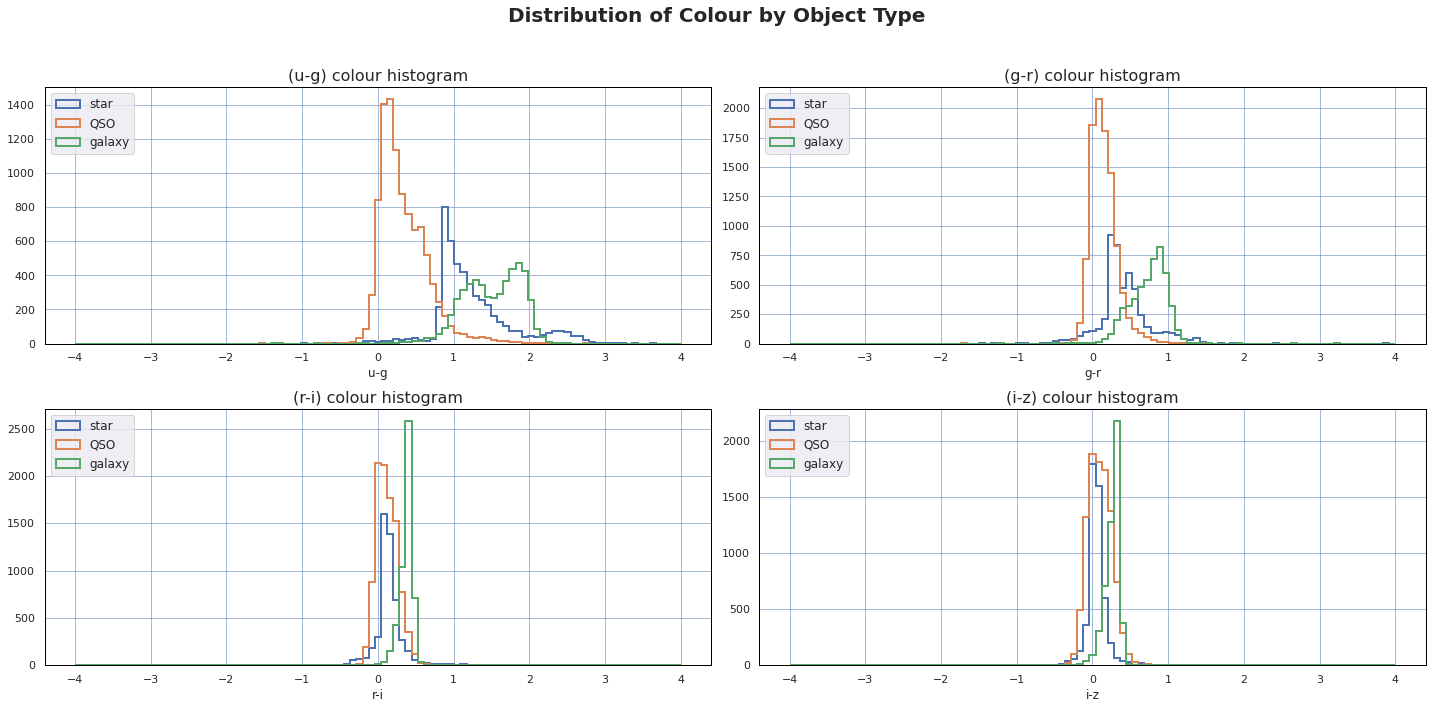

In [15]:
# Plotting colours per object type
colour = ['u-g','g-r','r-i','i-z']

# Create subplots and plot histograms
bins = np.linspace(-4, 4, 100)
fig,axs = plt.subplots(2,2, figsize=(20,10), edgecolor='black')
axs = axs.ravel()

for i, n in enumerate(colour):
    ax = axs[i]
    X = data_colour[n]
    #create the histograms for the object type per colour
    ax.hist(X.loc[data_colour['nClass']==1], bins,histtype='step', linewidth=2,label='star')
    ax.hist(X.loc[data_colour['nClass']==2], bins,histtype='step', linewidth=2, label='QSO')
    ax.hist(X.loc[data_colour['nClass']==3], bins,histtype='step', linewidth=2, label='galaxy')
    # Making it pretty with frame and grid
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.grid(color='b', linestyle='-', linewidth=0.5)
    ax.set_facecolor('xkcd:white')
    #set legend, lables and title
    ax.legend(loc='upper left',fontsize=12)
    ax.set_xlabel(n)
    ax.set_title(f'({n}) colour histogram', fontsize=16)
    
fig.suptitle('Distribution of Colour by Object Type', fontsize=20, fontweight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

For stars, in the (u-g) and (g-r) distributions, I was expecting to see a bimodality which would indicate the star is a hot blue star (to the left of the distribution) or a cold red star(to the right). But the distribution on our sample shows no bimodality and has a taile towards redder colours. The distribution of stars seems to be between the destributions of QSOs and galaxies for all colours. 

For QSOs, the (u-g) distribution peak is much bluer than that of stars and galaxies. It is as expected since what we see in QSOs are the active galactic nuclei(AGN, supermassive black holes) that outshine the stars of their host galaxies. The radiation peaks at the blue end of the spectrum. In the other colours, the distribution is also bluer than the galaxy distribution. 

For galaxies, there is a bimodal distribution in the (u-g) and the (g-r) distribution has a bump on the left side of the distribution. What we are seeing here is two populations; one population of young blue galaxies and the other of old red galaxies. On the other hand, the distributions of (r-i) and (i-z) show a very narrow distribution with a high peak. This could be due to the fact that we are sampling interstellar dust. Dust can absorb or scatter the light emitted by stars in a galaxy which makes the galaxy appear redder than it actually is. These distributions can be affected by the limited wavelength coverage of the bands.

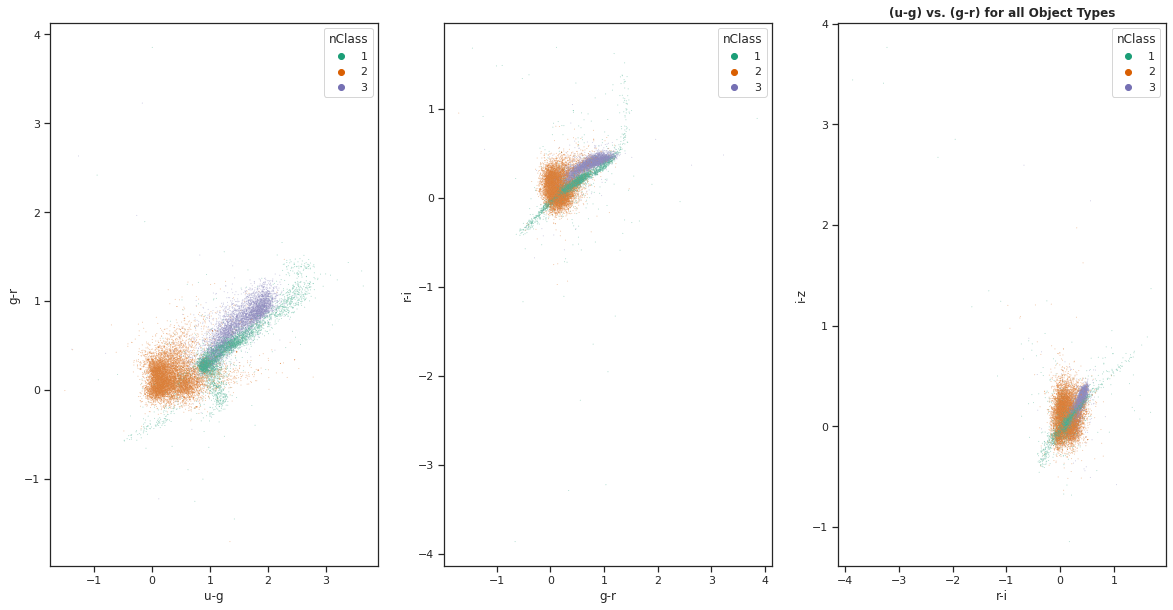

In [16]:
#Scatter plot hued by classes

sns.set_style("ticks")
  
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
sns.scatterplot(ax= axs[0], x="u-g", y="g-r", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)
sns.scatterplot(ax= axs[1], x="g-r", y="r-i", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)
sns.scatterplot(ax= axs[2], x="r-i", y="i-z", data= data_colour, hue='nClass', palette = 'Dark2',
             s = 1, alpha = 0.4)

# Add title and legend
plt.title('(u-g) vs. (g-r) for all Object Types', fontweight="bold")
#plt.legend( objects,fontsize=10, loc='upper left')
#plt.savefig('/home/veroastro/Documents/spectraTypes/images/scatter_classes.pdf')
plt.show()

The (u-g) vs (g-r) plot shows that the different classes occupy somewhat different regions of colour space.  Although there is the plenty intersection between them. In the other two plots the regions are less well defined. 

# Models and Analysis

In order to compare the results of our analysis, we use the dataset with the photometric redshift(photoZ). We calculate the mse of the photoZ with respect to the spectroscopic redshifht(z). It is important to note that this is done with different dataset from the one used to build the models. I do this because our dataset has a fainter (larger value of magnitudes) and the distribution of redshift also tends to higher values(more distant)then the dataset with photoZ. 

In [17]:
from sklearn.metrics import mean_squared_error

photozErr= data.loc[(data['photoZ'] >= 0.0)]['photoZ']
sZ= data.loc[(data['photoZ'] >= 0.0)]['z']
print('Mean Square Error PhotoZ:', round(mean_squared_error(sZ,photozErr), 3))

Mean Square Error PhotoZ: 0.054


The majority of the population on the dataset has a redshift less than 1. Because this might imbalance in the representation of the range of redshift available, I decided to do build the models and do the analysis on different subsets of the data. I divided the data into low with objects whose z is less or equal than 1 and high whith objects whose z is more than 1.

In [18]:
# Percentage of objects in each subset
print(f'Low Subset {round((data_cl.loc[(data_cl["z"] <= 1.0 )]["z"].count()/data_cl["z"].count()*100),2)} %')
print(f'High Subset {round((data_cl.loc[(data_cl["z"] > 1.0 )]["z"].count()/data_cl["z"].count()*100),2)} %')

Low Subset 57.33 %
High Subset 42.67 %


## Models

I use to learning algorithms to determine the redshifts: K-neighbor Regressor and Suppor Vector Regressor. 

### Full Dataset
#### Data Selection and Preprocessing

In [19]:
from sklearn.preprocessing import RobustScaler
# separating feature X and label y and scaling data 
X = data_cl.drop(['nClass', 'z'], axis=1)
y = data_cl['z']
# Using RobustScaler to scale the dataset
scaler = RobustScaler()
X_t = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_t, columns = X.columns)

In [20]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {X_train["dered_u"].count()}')
print(f'Count of X_test = {X_test["dered_u"].count()}')

Count of X_train = 13948
Count of X_test = 5979


The test error of the linear regression model is (mse) 0.058 while we get an mse of 0.049 with random forest regressor. To compare errors the mse from the difference between photometric redshift and spectroscopic redshift is 0.068. Here there are values of photoz of -999.0. This are the same as missing values so they are taken out of the calculation of mse.

#### Model Contruction and Analysis KNN

In [21]:
from sklearn.neighbors import KNeighborsRegressor
# calculating the accuracy of models with different values of k
n= 20
mse = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    mse[i-1] = mean_squared_error(y_test, yhat)

mse

array([0.31637866, 0.25670992, 0.23756514, 0.23293284, 0.22750975,
       0.22404727, 0.22447016, 0.22571966, 0.22659604, 0.22660137,
       0.22755958, 0.22911585, 0.22968594, 0.22959383, 0.23078492,
       0.23185023, 0.23162902, 0.23257313, 0.23321415, 0.23430482])

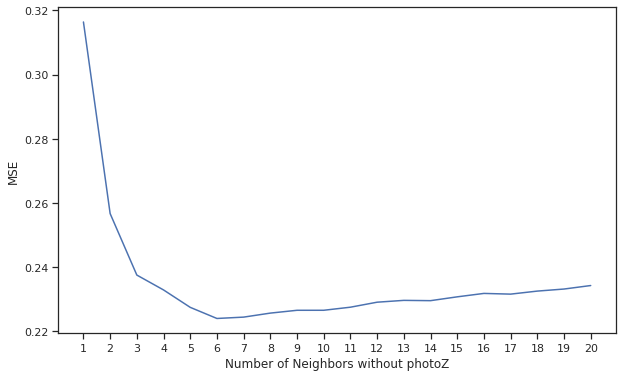

In [22]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse)
plt.xticks(loc)
plt.xlabel('Number of Neighbors without photoZ')
plt.ylabel('MSE')
plt.show()


In [23]:
from sklearn.model_selection import GridSearchCV
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [6,7,8],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR = knr.fit(X_train, y_train)

In [24]:
KNR.best_params_

{'algorithm': 'auto',
 'leaf_size': 3,
 'n_neighbors': 8,
 'p': 1,
 'weights': 'distance'}

In [25]:
# fit the model and predict the class
y_pred_knr = KNR.predict(X_test)

In [26]:
# Mean squared error
mse_KNR_all = mean_squared_error(y_test,y_pred_knr)
print('Mean Square Error KNN:', round(mse_KNR_all, 3))

Mean Square Error KNN: 0.214


#### Model Contruction and Analysis Support Vector Machine

In [27]:
from sklearn.svm import SVR
# Use the random grid to search for best hyperparameters
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'sigmoid']} 
#Setting the GridsherchCV 
SVR_grid = GridSearchCV(SVR(), param_grid,  n_jobs = -1) 
# fitting the model for grid search
svr = SVR_grid.fit(X_train, y_train)

# print best parameter after tuning 
svr.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [28]:
#predicting the values and calculating the mse
y_pred_SVR = svr.predict(X_test)
mse_SVR = mean_squared_error(y_test,y_pred_SVR)
print('Mean Square Error SVR:', round(mse_SVR, 3))

Mean Square Error SVR: 0.251


### Subset Low (z <= 1)
#### Data Selection and Preprocessing

In [33]:
# Subsetting the dataset by selecting from the full dataset only sources with z<=1
data_low = data_cl.loc[(data_cl['z'] <= 1.0 )]
data_low.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
2728,20.56905,17.48284,16.19343,15.66441,15.37556,0.000678,1
1013,18.36501,17.33097,16.94222,16.72284,16.62204,0.032906,3
1744,15.88625,14.84572,14.63811,14.58453,14.61692,0.000001,1
4094,20.22675,18.51591,17.39308,16.89989,16.54217,0.159147,3
1602,19.43867,17.27449,16.44771,16.19131,16.08365,0.000081,1


In [34]:
# separating feature X and label y and scaling data 
X =data_low.drop(['nClass', 'z'], axis=1)
y = data_low['z']
# Using RobustScaler to scale the dataset
X_t_low = scaler.fit_transform(X)
X_scaled_low = pd.DataFrame(X_t_low, columns = X.columns)
# Split the data into training and test sets
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_scaled_low, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xl_train["dered_u"].count()}')
print(f'Count of X_test = {Xl_test["dered_u"].count()}')


Count of X_train = 7997
Count of X_test = 3428


#### Model Contruction and Analysis KNN

In [35]:
# Calculating the mse for a range of values to select the best range.
mse_low = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xl_train,yl_train)
    yhat= knn.predict(Xl_test)
    mse_low[i-1] = mean_squared_error(yl_test, yhat)

mse_low

array([0.00989166, 0.00854885, 0.00756829, 0.00704533, 0.00688283,
       0.00687483, 0.00687887, 0.00694692, 0.00706191, 0.00704956,
       0.00711425, 0.00726144, 0.00744495, 0.00749654, 0.0075963 ,
       0.00772621, 0.00782494, 0.00793803, 0.00808617, 0.00819279])

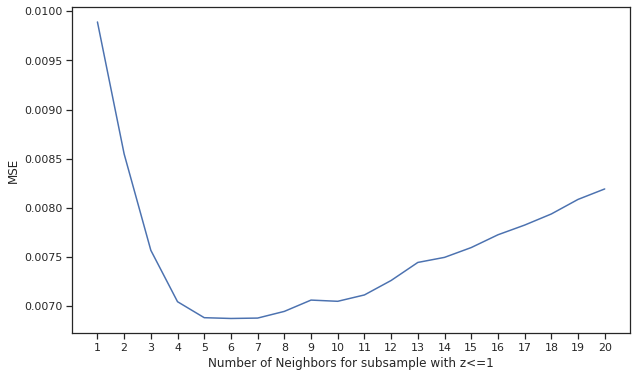

In [36]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_low)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample with z<=1')
plt.ylabel('MSE')
plt.show()


In [37]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [ 5, 6, 7],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_low = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_low = knr_low.fit(Xl_train, yl_train)

In [38]:
KNR_low.best_params_ 

{'algorithm': 'auto',
 'leaf_size': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

In [39]:
# fit the model and predict the class
yl_pred_knr = KNR_low.predict(Xl_test)

In [40]:
# Mean squared error
mse_KNR_low = mean_squared_error(yl_test,yl_pred_knr)
print('Mean Square Error KNN for z < 1 :', round(mse_KNR_low, 3))

Mean Square Error KNN for z < 1 : 0.007


#### Model Contruction and Analysis Support Vector Machine

In [41]:
# fitting the model for grid search
svr_low = SVR_grid.fit(Xl_train, yl_train)

# print best parameter after tuning 
svr_low.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [42]:
#predicting the values and calculating the mse
yl_pred_SVR = svr_low.predict(Xl_test)
mse_SVR_low = mean_squared_error(yl_test,yl_pred_SVR)
print('Mean Square Error SVR for z<=1:', round(mse_SVR_low, 3))

Mean Square Error SVR for z<=1: 0.008


### Subset high (z > 1)
#### Data Selection and Preprocessing

In [43]:
# Subsetting the dataset by selecting from the full dataset only sources with z<=1
data_high = data_cl.loc[(data_cl['z'] > 1.0 )]
data_high.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass
1306,20.67431,20.25327,20.03435,19.98915,19.71827,2.456878,2
668,20.13697,20.03177,19.75809,19.74050,19.90595,1.060059,2
837,18.26477,17.86617,17.68207,17.46004,17.20513,2.122566,2
2614,19.20903,18.96301,18.66391,18.76042,18.88937,1.100385,2
2175,21.05627,20.74837,20.52937,20.29080,20.22308,2.020439,2


In [44]:
# separating feature X and label y and scaling data 
X = data_high.drop(['nClass', 'z'], axis=1)
y = data_high['z']
# Using RobustScaler to scale the dataset
X_t_high = scaler.fit_transform(X)
X_scaled_high = pd.DataFrame(X_t_high, columns = X.columns)
# Split the data into training and test sets
Xh_train, Xh_test, yh_train, yh_test = train_test_split(X_scaled_high, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xh_train["dered_u"].count()}')
print(f'Count of X_test = {Xh_test["dered_u"].count()}')


Count of X_train = 5951
Count of X_test = 2551


#### Model Contruction and Analysis KNN

In [45]:
# Calculating the mse for a range of values to select the best range.
mse_high = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xh_train,yh_train)
    yhat= knn.predict(Xh_test)
    mse_high[i-1] = mean_squared_error(yh_test, yhat)

mse_high

array([0.10872438, 0.084301  , 0.07749739, 0.07321002, 0.07063255,
       0.06871644, 0.06926688, 0.06856891, 0.06863553, 0.06849319,
       0.06899406, 0.06966458, 0.06914388, 0.06915679, 0.06944659,
       0.06989758, 0.07022726, 0.0702489 , 0.07073013, 0.07073159])

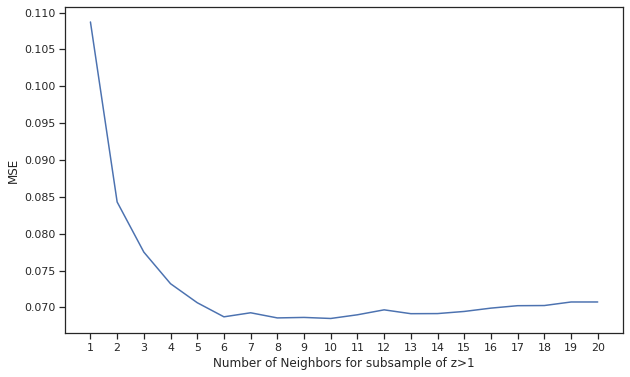

In [46]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_high)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample of z>1')
plt.ylabel('MSE')
plt.show()


In [47]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [6, 7 ,8, 9],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_high = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_high = knr_high.fit(Xh_train, yh_train)

In [48]:
KNR_high.best_params_ 

{'algorithm': 'auto',
 'leaf_size': 2,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'distance'}

In [49]:
# fit the model and predict the class
yh_pred_knr = KNR_high.predict(Xh_test)

In [50]:
# Mean squared error
mse_KNR_high = mean_squared_error(yh_test,yh_pred_knr)
print('Mean Square Error KNN for z > 1 :', round(mse_KNR_high, 3))

Mean Square Error KNN for z > 1 : 0.067


#### Model Contruction and Analysis Support Vector Machine

In [51]:
# fitting the model for grid search
svr_high = SVR_grid.fit(Xh_train, yh_train)

# print best parameter after tuning and best accuracy
svr_high.best_params_, svr_high.best_score_

({'C': 10, 'gamma': 1, 'kernel': 'rbf'}, 0.745161359105559)

In [52]:
#predicting the values and calculating the mse
yh_pred_SVR = svr_high.predict(Xh_test)
mse_SVR_high = mean_squared_error(yh_test,yh_pred_SVR)
print('Mean Square Error SVR:', round(mse_SVR_high, 3))

Mean Square Error SVR: 0.067


### All results together

In [53]:
from tabulate import tabulate
#create data
tab_data = [["All", round(mse_KNR_all, 3), round(mse_SVR, 3)], 
        ["Low",  round(mse_KNR_low, 3),  round(mse_SVR_low, 3)], 
        ["High",  round(mse_KNR_high, 3),  round(mse_SVR_high, 3)]]
  
#define header names
col_names = ["Dataset","MSE KNR", "MSE SVR"]
  
#display table
print(tabulate(tab_data, headers=col_names))


Dataset      MSE KNR    MSE SVR
---------  ---------  ---------
All            0.214      0.251
Low            0.007      0.008
High           0.067      0.067


## Adding Colours
### Full Dataset
#### Data Selection and Preprocessing

In [54]:
# separating feature X and label y and scaling data 
X = data_colour.drop(['nClass', 'z'], axis=1)
y = data_colour['z']
# Using RobustScaler to scale the dataset
X_t_c = scaler.fit_transform(X)
X_scaled_c = pd.DataFrame(X_t_c, columns = X.columns)


In [55]:
# Split the data into training and test sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled_c, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {X_train_c["dered_u"].count()}')
print(f'Count of X_test = {X_test_c["dered_u"].count()}')

Count of X_train = 13948
Count of X_test = 5979


#### Model Contruction and Analysis KNN

In [56]:
# calculating the accuracy of models with different values of k
n= 20
mse_c = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(X_train_c,y_train_c)
    yhat= knn.predict(X_test_c)
    mse_c[i-1] = mean_squared_error(y_test_c, yhat)

mse_c

array([0.29395638, 0.22364351, 0.19514351, 0.1849585 , 0.18117965,
       0.17736446, 0.17604967, 0.1750067 , 0.17458257, 0.17425391,
       0.17567316, 0.17588769, 0.17675099, 0.17818985, 0.17837787,
       0.17797122, 0.17963348, 0.18035334, 0.1800423 , 0.18003091])

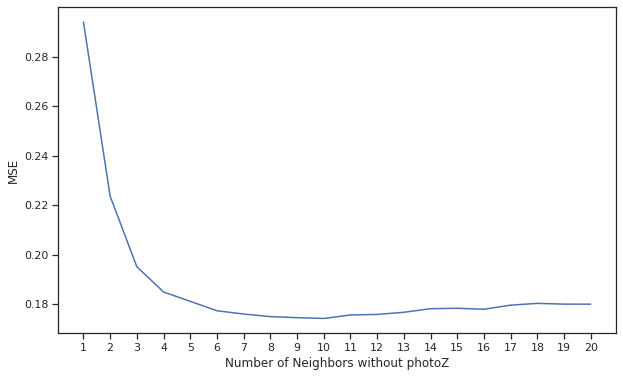

In [57]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_c)
plt.xticks(loc)
plt.xlabel('Number of Neighbors without photoZ')
plt.ylabel('MSE')
plt.show()


In [64]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [8, 9, 10],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_c = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_c = knr_c.fit(X_train_c, y_train_c)

In [65]:
KNR_c.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 6,
 'n_neighbors': 10,
 'p': 2,
 'weights': 'distance'}

In [60]:
# fit the model and predict the class
y_pred_knr_c = KNR_c.predict(X_test_c)

In [61]:
# Mean squared error
mse_KNR_all_c = mean_squared_error(y_test_c,y_pred_knr_c)
print('Mean Square Error KNN:', round(mse_KNR_all_c, 3))

Mean Square Error KNN: 0.167


#### Model Contruction and Analysis Support Vector Machine

In [62]:
# fitting the model for grid search
svr_c = SVR_grid.fit(X_train_c, y_train_c)

# print best parameter after tuning 
svr_c.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [63]:
#predicting the values and calculating the mse
y_pred_SVR_c = svr_c.predict(X_test_c)
mse_SVR_c = mean_squared_error(y_test_c,y_pred_SVR_c)
print('Mean Square Error SVR:', round(mse_SVR_c, 3))

Mean Square Error SVR: 0.182


### Subset Low (z <= 1)
#### Data Selection and Preprocessing

In [66]:
# Subsetting the dataset by selecting from the full dataset only sources with z<=1
data_low_c = data_colour.loc[(data_colour['z'] <= 1.0 )]
data_low_c.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass,u-g,g-r,r-i,i-z
2728,20.56905,17.48284,16.19343,15.66441,15.37556,0.000678,1,3.08621,1.28941,0.52902,0.28885
1013,18.36501,17.33097,16.94222,16.72284,16.62204,0.032906,3,1.03404,0.38875,0.21938,0.10080
1744,15.88625,14.84572,14.63811,14.58453,14.61692,0.000001,1,1.04053,0.20761,0.05358,-0.03239
4094,20.22675,18.51591,17.39308,16.89989,16.54217,0.159147,3,1.71084,1.12283,0.49319,0.35772
1602,19.43867,17.27449,16.44771,16.19131,16.08365,0.000081,1,2.16418,0.82678,0.25640,0.10766


In [67]:
# separating feature X and label y and scaling data 
X =data_low_c.drop(['nClass', 'z'], axis=1)
y = data_low_c['z']
# Using RobustScaler to scale the dataset
X_t_low_c = scaler.fit_transform(X)
X_scaled_low_c= pd.DataFrame(X_t_low_c, columns = X.columns)
# Split the data into training and test sets
Xl_train_c, Xl_test_c, yl_train_c, yl_test_c = train_test_split(X_scaled_low_c, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xl_train_c["dered_u"].count()}')
print(f'Count of X_test = {Xl_test_c["dered_u"].count()}')


Count of X_train = 7997
Count of X_test = 3428


#### Model Contruction and Analysis KNN

In [68]:
# Calculating the mse for a range of values to select the best range.
n=20
mse_low_c= np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xl_train_c,yl_train_c)
    yhat= knn.predict(Xl_test_c)
    mse_low_c[i-1] = mean_squared_error(yl_test_c, yhat)

mse_low_c

array([0.00668031, 0.00543043, 0.00462057, 0.0045758 , 0.00463409,
       0.00450505, 0.00446762, 0.00461845, 0.00463745, 0.00473643,
       0.00487958, 0.00492231, 0.00502578, 0.00511772, 0.0051249 ,
       0.00513263, 0.00517958, 0.00522249, 0.00522899, 0.00524169])

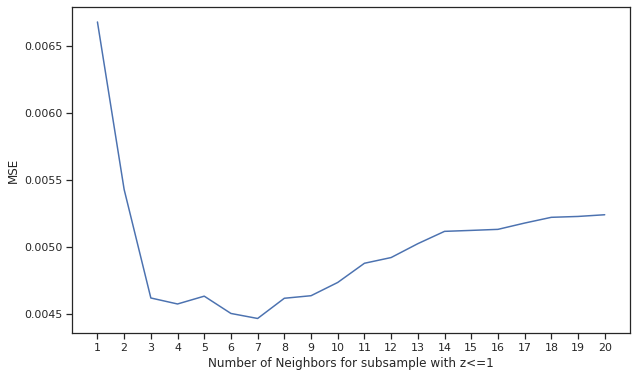

In [69]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_low_c)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample with z<=1')
plt.ylabel('MSE')
plt.show()


In [70]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': [6, 7, 8],
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_low_c = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_low_c = knr_low_c.fit(Xl_train_c, yl_train_c)

In [71]:
KNR_low_c.best_params_ 

{'algorithm': 'ball_tree',
 'leaf_size': 7,
 'n_neighbors': 6,
 'p': 2,
 'weights': 'distance'}

In [72]:
# fit the model and predict the class
yl_pred_knr_c = KNR_low_c.predict(Xl_test_c)

In [73]:
# Mean squared error
mse_KNR_low_c = mean_squared_error(yl_test_c,yl_pred_knr_c)
print('Mean Square Error KNN for z < 1 :', round(mse_KNR_low_c, 3))

Mean Square Error KNN for z < 1 : 0.004


#### Model Contruction and Analysis Support Vector Machine

In [74]:
# fitting the model for grid search
svr_low_c = SVR_grid.fit(Xl_train_c, yl_train_c)

# print best parameter after tuning 
svr_low_c.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [75]:
#predicting the values and calculating the mse
yl_pred_SVR_c = svr_low_c.predict(Xl_test_c)
mse_SVR_low_c = mean_squared_error(yl_test_c,yl_pred_SVR_c)
print('Mean Square Error SVR for z<=1:', round(mse_SVR_low_c, 3))

Mean Square Error SVR for z<=1: 0.007


### Subset high (z > 1)
#### Data Selection and Preprocessing

In [76]:
# Subsetting the dataset by selecting from the full dataset only sources with z<=1
data_high_c = data_colour.loc[(data_colour['z'] > 1.0 )]
data_high_c.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z,nClass,u-g,g-r,r-i,i-z
1306,20.67431,20.25327,20.03435,19.98915,19.71827,2.456878,2,0.42104,0.21892,0.04520,0.27088
668,20.13697,20.03177,19.75809,19.74050,19.90595,1.060059,2,0.10520,0.27368,0.01759,-0.16545
837,18.26477,17.86617,17.68207,17.46004,17.20513,2.122566,2,0.39860,0.18410,0.22203,0.25491
2614,19.20903,18.96301,18.66391,18.76042,18.88937,1.100385,2,0.24602,0.29910,-0.09651,-0.12895
2175,21.05627,20.74837,20.52937,20.29080,20.22308,2.020439,2,0.30790,0.21900,0.23857,0.06772


In [77]:
# separating feature X and label y and scaling data 
X = data_high_c.drop(['nClass', 'z'], axis=1)
y = data_high_c['z']
# Using RobustScaler to scale the dataset
X_t_high_c = scaler.fit_transform(X)
X_scaled_high_c = pd.DataFrame(X_t_high_c, columns = X.columns)
# Split the data into training and test sets
Xh_train_c, Xh_test_c, yh_train_c, yh_test_c = train_test_split(X_scaled_high_c, y, test_size=0.3, random_state=42)

print(f'Count of X_train = {Xh_train_c["dered_u"].count()}')
print(f'Count of X_test = {Xh_test_c["dered_u"].count()}')


Count of X_train = 5951
Count of X_test = 2551


#### Model Contruction and Analysis KNN

In [78]:
# Calculating the mse for a range of values to select the best range.
n=50
mse_high_c = np.zeros(n)
for i in range(1,n+1):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i).fit(Xh_train_c,yh_train_c)
    yhat= knn.predict(Xh_test_c)
    mse_high_c[i-1] = mean_squared_error(yh_test_c, yhat)

mse_high_c

array([0.09592802, 0.07514801, 0.06798268, 0.06546518, 0.06258901,
       0.06092343, 0.05948992, 0.05873155, 0.05809608, 0.05731706,
       0.05653675, 0.05614913, 0.05573424, 0.05554946, 0.05537464,
       0.05525805, 0.05495866, 0.05502716, 0.05486009, 0.05506896,
       0.05488531, 0.05489003, 0.05485047, 0.0549692 , 0.0545771 ,
       0.05460151, 0.05472166, 0.05479071, 0.0549254 , 0.0548974 ,
       0.05459691, 0.05467574, 0.05469384, 0.05486128, 0.05493781,
       0.05490298, 0.05484822, 0.05500917, 0.05498088, 0.05495916,
       0.05496678, 0.05484961, 0.05484334, 0.05478002, 0.05489758,
       0.0549675 , 0.05500259, 0.05504324, 0.05514108, 0.05518906])

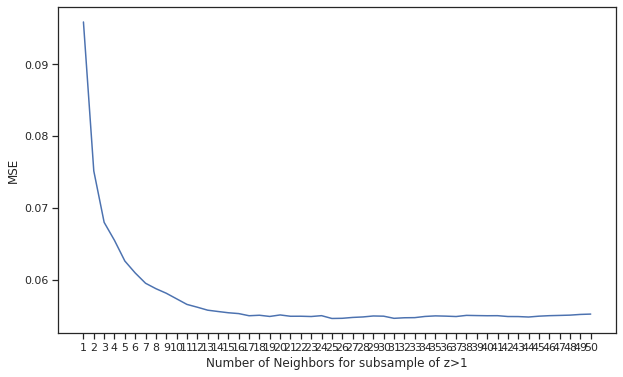

In [79]:
# Plotting the mse obtained against the number of neighbours
loc = np.arange(1,n+1,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, n+1), mse_high_c)
plt.xticks(loc)
plt.xlabel('Number of Neighbors for subsample of z>1')
plt.ylabel('MSE')
plt.show()


In [80]:
# Defining the grid of parameters for the gridSearchCV
param_grid = {  'weights' : ['uniform', 'distance'],
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                'leaf_size': range(1, 10),
                'n_neighbors': range(20,25),
                'p' : [1, 2]
             }
# Setting and fitting gridsearchCV to the dataset 
knr_high_c = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs = -1 )
KNR_high_c = knr_high.fit(Xh_train_c, yh_train_c)

In [81]:
KNR_high_c.best_params_ 

{'algorithm': 'auto',
 'leaf_size': 3,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'distance'}

In [82]:
# fit the model and predict the class
yh_pred_knr_c = KNR_high_c.predict(Xh_test_c)

In [83]:
# Mean squared error
mse_KNR_high_c = mean_squared_error(yh_test_c,yh_pred_knr_c)
print('Mean Square Error KNN for z > 1 :', round(mse_KNR_high_c, 3))

Mean Square Error KNN for z > 1 : 0.058


#### Model Contruction and Analysis Support Vector Machine

In [84]:
# fitting the model for grid search
svr_high_c = SVR_grid.fit(Xh_train_c, yh_train_c)

# print best parameter after tuning 
svr_high_c.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [85]:
#predicting the values and calculating the mse
yh_pred_SVR_c = svr_high_c.predict(Xh_test_c)
mse_SVR_high_c = mean_squared_error(yh_test_c,yh_pred_SVR_c)
print('Mean Square Error SVR:', round(mse_SVR_high_c, 3))

Mean Square Error SVR: 0.058


### All results together of Coloured data

In [86]:
#create data
tab_data_c = [["All", round(mse_KNR_all_c, 3), round(mse_SVR_c, 3)], 
        ["Low",  round(mse_KNR_low_c, 3),  round(mse_SVR_low_c, 3)], 
        ["High",  round(mse_KNR_high_c, 3),  round(mse_SVR_high_c, 3)]]
  
#define header names
col_names_c = ["Dataset colour","MSE KNR", "MSE SVR"]
  
#display table
print(tabulate(tab_data_c, headers=col_names_c))


Dataset colour      MSE KNR    MSE SVR
----------------  ---------  ---------
All                   0.167      0.182
Low                   0.004      0.007
High                  0.058      0.058


In [87]:
print(tabulate(tab_data, headers=col_names))

Dataset      MSE KNR    MSE SVR
---------  ---------  ---------
All            0.214      0.251
Low            0.007      0.008
High           0.067      0.067


## Conclusion

I added 5000 sources with high redshift to the original 15000 sample. I found that there were 73 duplicates when adding the extraZ dataset. The percentage of sources in the low and high subsets are now closer to equal (57% and 43% respectively). This augmentation of the dataset did improve the mse of the high redshift subsample 0.08 to 0.058 but it failed to improve the full dataset model from 0.149 to 0.167. 